In [1]:
!pip install deepforest

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.0 MB/s eta 0:00:00
  Created

In [2]:
import json
import deepforest
from deepforest import main
from deepforest import get_data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.models as models
import pandas as pd
import os
from PIL import Image
from PIL import ImageDraw
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
!wget https://zenodo.org/records/6813783/files/reforesTree.zip?download=1

--2024-10-21 11:28:03--  https://zenodo.org/records/6813783/files/reforesTree.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7514326095 (7.0G) [application/octet-stream]
Saving to: ‘reforesTree.zip?download=1’

reforesTree.zip?dow 100%[===================>]   7.00G  15.7MB/s    in 7m 12s  

2024-10-21 11:35:16 (16.6 MB/s) - ‘reforesTree.zip?download=1’ saved [7514326095/7514326095]



In [4]:
!unzip /content/reforesTree.zip?download=1

Archive:  /content/reforesTree.zip?download=1
mapname:  conversion of  failed
   creating: model/
   creating: tiles/
   creating: mapping/
   creating: annotations/
   creating: wwf_ecuador/
 extracting: field_data.csv          
   creating: model/deepforest/
   creating: annotations/cleaned/
 extracting: tiles/ortho_data.csv    
   creating: tiles/Flora Pluas RGB/
   creating: wwf_ecuador/Final_Trees/
   creating: tiles/Manuel Macias RGB/
   creating: tiles/Nestor Macias RGB/
   creating: tiles/Leonor Aspiazu RGB/
 extracting: mapping/final_dataset.csv  
 extracting: wwf_ecuador/Referencia.xlsx  
   creating: wwf_ecuador/RGB Orthomosaics/
   creating: tiles/Carlos Vera Arteaga RGB/
   creating: tiles/Carlos Vera Guevara RGB/
   creating: wwf_ecuador/Merged_final_plots/
 extracting: annotations/all_annotations.csv  
 extracting: wwf_ecuador/Final_Trees/Final_Trees.sbn  
 extracting: wwf_ecuador/Final_Trees/Final_Trees.prj  
 extracting: wwf_ecuador/Final_Trees/Final_Trees.cpg  
 extra

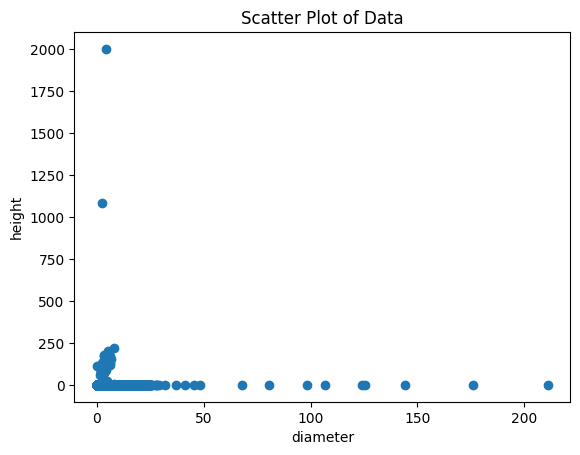

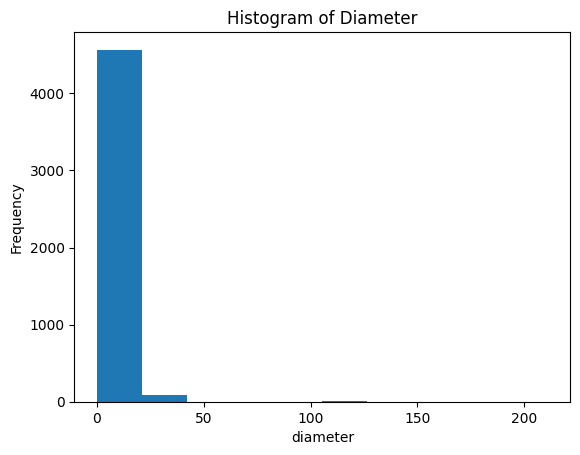

In [5]:
# prompt: visualize data from /content/field_data.csv

import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
df = pd.read_csv('/content/field_data.csv')

# Example visualization: Scatter plot of two columns
plt.scatter(df['diameter'], df['height'])
plt.xlabel('diameter')
plt.ylabel('height')
plt.title('Scatter Plot of Data')
plt.show()

# You can replace 'column_name_1' and 'column_name_2' with the actual column names in your CSV file.
# You can also choose different types of visualizations like histograms, bar plots, etc. based on your data.

# Example: Histogram of a single column
plt.hist(df['diameter'], bins=10)
plt.xlabel('diameter')
plt.ylabel('Frequency')
plt.title('Histogram of Diameter')
plt.show()

In [6]:
# Define the MLP head with two outputs
class MLPRegressionHead(nn.Module):
    def __init__(self, in_features, hidden_dim=256):
        super(MLPRegressionHead, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)  # Output two values: AGB and Carbon Content

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        outputs = self.fc3(x)  # Two outputs, one for AGB and one for Carbon Content
        return outputs


In [7]:
class MLPRegressionHead_Resnet(nn.Module):
    def __init__(self, in_features=2048, hidden_dim=256):
        super(MLPRegressionHead_Resnet, self).__init__()
        self.fc1 = nn.Linear(in_features, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x


In [8]:
# Define the MLP for processing additional features
class FeatureMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(FeatureMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


In [39]:
class ModifiedDeepForestAGB_CC_Resnet(nn.Module):
    def __init__(self, mlp_hidden_dim=256, feature_dim=12, feature_hidden_dim=128, freeze_backbone=True):
        super(ModifiedDeepForestAGB_CC_Resnet, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Pass the output directly

        # Add the avgpool layer from the original ResNet architecture
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # For ResNet18, backbone output size is 512
        backbone_features = 512

        # MLP for processing additional features
        self.feature_mlp = FeatureMLP(input_dim=feature_dim, hidden_dim=feature_hidden_dim)

        # Total features after concatenation
        total_features = backbone_features + feature_hidden_dim

        # Define the MLP regression head with two outputs
        self.mlp_head = MLPRegressionHead_Resnet(in_features=total_features, hidden_dim=mlp_hidden_dim)

    def forward(self, x, additional_features):
        # Extract features using the backbone
        backbone_features = self.backbone(x)

        # Debug print to check the shape of the backbone output
        # print("Shape of backbone_features before avgpool:", backbone_features.shape)

        # Ensure the backbone features are 4D before applying pooling
        if backbone_features.dim() == 2:  # (batch_size, backbone_features) -> add spatial dimensions
            backbone_features = backbone_features.unsqueeze(-1).unsqueeze(-1)

        # Apply average pooling and flatten the feature map
        pooled_backbone_features = self.avgpool(backbone_features)
        flattened_backbone_features = torch.flatten(pooled_backbone_features, 1)

        # Process additional features through the MLP
        processed_features = self.feature_mlp(additional_features)

        # Concatenate the backbone features with the processed additional features
        combined_features = torch.cat([flattened_backbone_features, processed_features], dim=1)

        # Pass the combined features through the MLP regression head
        agb_cc_outputs = self.mlp_head(combined_features)

        # Split the outputs into AGB and Carbon Content
        agb_output, cc_output = agb_cc_outputs[:, 0], agb_cc_outputs[:, 1]

        return agb_output, cc_output


In [30]:
class TreeDataset(Dataset): #Dataset
    def __init__(self, csv_file, img_root, transform=None):
        self.img_root = img_root
        self.transform = transform

        # Read and process the CSV file
        self.data = pd.read_csv(csv_file)

        # Assuming your csv has columns 'image_name', 'AGB', 'carbon'
        # self.image_names = self.data['image_name'].tolist()
        # self.agb_values = self.data['AGB'].tolist()
        # self.carbon_values = self.data['carbon'].tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load the row data
        row = self.data.iloc[idx]

        # Load the image
        img_path = os.path.join(self.img_root, row['img_name'], row['img_path'])
        image = Image.open(img_path).convert("RGB")

        # Crop the image using xmin, ymin, xmax, ymax
        xmin = int(row['xmin'])
        ymin = int(row['ymin'])
        xmax = int(row['xmax'])
        ymax = int(row['ymax'])
        cropped_image = image.crop((xmin, ymin, xmax, ymax))

        # Apply any transformations
        if self.transform:
            cropped_image = self.transform(cropped_image)

        # Calculate area using Xmin, Ymin, Xmax, Ymax
        area = (row['Xmax'] - row['Xmin']) * (row['Ymax'] - row['Ymin'])

        # Extract features
        features = torch.tensor([
            row['xmin'],
            row['ymin'],
            row['xmax'],
            row['ymax'],
            row['score'],
            row['is_musacea_d'],
            row['is_banana'],
            row['diameter'],
            row['height'],
            row['updated diameter'],
            row['updated height'],
            area
        ], dtype=torch.float32)

        # Extract labels
        labels = torch.tensor([row['AGB'], row['carbon']], dtype=torch.float32)

        return cropped_image, features, labels

In [40]:
def train_model(model, train_loader, criterion, optimizer, device, writer, epoch):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_mae_agb = 0.0
    running_mae_cc = 0.0

    for i, (images, features, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)  # Move images to device (GPU or CPU)
        features = features.to(device)  # Move features to device
        labels = labels.to(device)  # Move labels to device

        optimizer.zero_grad()

        # Forward pass
        agb_output, cc_output = model(images, features)
        loss_agb = criterion(agb_output, labels[:, 0])  # AGB loss
        loss_cc = criterion(cc_output, labels[:, 1])  # Carbon Content loss
        loss = loss_agb + loss_cc

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate MAE for monitoring
        mae_agb = mean_absolute_error(labels[:, 0].cpu().detach().numpy(), agb_output.cpu().detach().numpy())
        mae_cc = mean_absolute_error(labels[:, 1].cpu().detach().numpy(), cc_output.cpu().detach().numpy())

        running_loss += loss.item()
        running_mae_agb += mae_agb
        running_mae_cc += mae_cc

        # Logging the training loss
        writer.add_scalar('Train/Loss', loss.item(), epoch * len(train_loader) + i)

    epoch_loss = running_loss / len(train_loader)
    epoch_mae_agb = running_mae_agb / len(train_loader)
    epoch_mae_cc = running_mae_cc / len(train_loader)

    return epoch_loss, epoch_mae_agb, epoch_mae_cc

In [41]:
def validate_model(model, val_loader, criterion, device, writer, epoch):
    model.eval()
    running_loss = 0.0
    running_mae_agb = 0.0
    running_mae_cc = 0.0

    with torch.no_grad():
        for i, (images, features, labels) in enumerate(tqdm(val_loader)):
            images = images.to(device)
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass
            agb_output, cc_output = model(images, features)
            loss_agb = criterion(agb_output, labels[:, 0])
            loss_cc = criterion(cc_output, labels[:, 1])
            loss = loss_agb + loss_cc

            # Calculate MAE
            mae_agb = mean_absolute_error(labels[:, 0].cpu().detach().numpy(), agb_output.cpu().detach().numpy())
            mae_cc = mean_absolute_error(labels[:, 1].cpu().detach().numpy(), cc_output.cpu().detach().numpy())

            running_loss += loss.item()
            running_mae_agb += mae_agb
            running_mae_cc += mae_cc

            writer.add_scalar('Validation/Loss', loss.item(), epoch * len(val_loader) + i)
            writer.add_scalar('Validation/MAE_AGB', mae_agb, epoch * len(val_loader) + i)
            writer.add_scalar('Validation/MAE_CC', mae_cc, epoch * len(val_loader) + i)

    epoch_loss = running_loss / len(val_loader)
    epoch_mae_agb = running_mae_agb / len(val_loader)
    epoch_mae_cc = running_mae_cc / len(val_loader)

    return epoch_loss, epoch_mae_agb, epoch_mae_cc

In [42]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_mae_agb = 0.0
    running_mae_cc = 0.0

    all_agb_outputs = []
    all_cc_outputs = []
    all_agb_labels = []
    all_cc_labels = []

    with torch.no_grad():
        for images, features, labels in tqdm(test_loader):
            images = images.to(device)
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass
            agb_output, cc_output = model(images, features)
            loss_agb = criterion(agb_output, labels[:, 0])
            loss_cc = criterion(cc_output, labels[:, 1])
            loss = loss_agb + loss_cc

            running_loss += loss.item()

            # Store outputs and labels for MAE calculation
            all_agb_outputs.extend(agb_output.cpu().numpy())
            all_cc_outputs.extend(cc_output.cpu().numpy())
            all_agb_labels.extend(labels[:, 0].cpu().numpy())
            all_cc_labels.extend(labels[:, 1].cpu().numpy())

    # Calculate MAE
    mae_agb = mean_absolute_error(all_agb_labels, all_agb_outputs)
    mae_cc = mean_absolute_error(all_cc_labels, all_cc_outputs)

    # Compute the overall loss
    epoch_loss = running_loss / len(test_loader)

    return epoch_loss, mae_agb, mae_cc

In [43]:
def run_testing():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load test dataset
    test_dataset = TreeDataset(csv_file='/content/test_dataset.csv', img_root='/content/tiles', transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

    # Load model
    model = load_modified_deepforest_model(freeze_backbone=True)
    model.load_state_dict(torch.load('Model_saves/deepforest_agb_cc_best.pth', map_location=device))  # Load the best model
    model = model.to(device)

    # Define loss function
    criterion = nn.MSELoss()  # Mean Squared Error for regression tasks

    # Test the model
    test_loss, test_mae_agb, test_mae_cc = test_model(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test MAE AGB: {test_mae_agb:.4f}, Test MAE CC: {test_mae_cc:.4f}')


In [44]:
# Function to load and modify the DeepForest model
def load_modified_deepforest_model(freeze_backbone=True, model_name='deepforest'):
    if model_name == 'deepforest':
        model = main.deepforest()
        model.use_release()

    else:
        model = models.resnet18(pretrained=True)
        # Remove the last layer
        model = nn.Sequential(*list(model.children())[:-1])

    # Define the feature dimension (e.g., 12 for your specified features)
    feature_dim = 12

    # Instantiate the modified model
    modified_model = ModifiedDeepForestAGB_CC_Resnet(model, feature_dim=feature_dim)

    # Freeze the backbone if specified
    if freeze_backbone:
        for param in modified_model.backbone.parameters():
            param.requires_grad = False

    return modified_model

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/content/mapping/final_dataset.csv'  # Update this path
df = pd.read_csv(file_path)

# Group the data by the 'name' field
grouped = df.groupby('name')

# Prepare lists to hold the data splits
train_list = []
val_list = []
test_list = []

# Improved logic for splitting small groups
for name, group in grouped:
    if len(group) == 1:
        # Assign the single sample to the training set
        train = group
        val, test = pd.DataFrame(), pd.DataFrame()
    elif len(group) == 2:
        # Assign one sample to train and the other to val/test
        train, val = group.iloc[:1], group.iloc[1:]
        test = pd.DataFrame()
    elif len(group) == 3:
        # Assign one sample to each split
        train, val, test = group.iloc[0:1], group.iloc[1:2], group.iloc[2:]
    else:
        # Standard splitting for larger groups
        train, temp = train_test_split(group, test_size=0.3, random_state=42)
        val, test = train_test_split(temp, test_size=0.5, random_state=42)

    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

# Concatenate the splits back into full DataFrames
train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

# Display the number of samples in each set
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Save the splits to separate CSV files
train_df.to_csv('train_dataset.csv', index=False)
val_df.to_csv('val_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)

print("Data splits saved to 'train_dataset.csv', 'val_dataset.csv', and 'test_dataset.csv'")

Training set size: 3253
Validation set size: 700
Test set size: 710
Data splits saved to 'train_dataset.csv', 'val_dataset.csv', and 'test_dataset.csv'


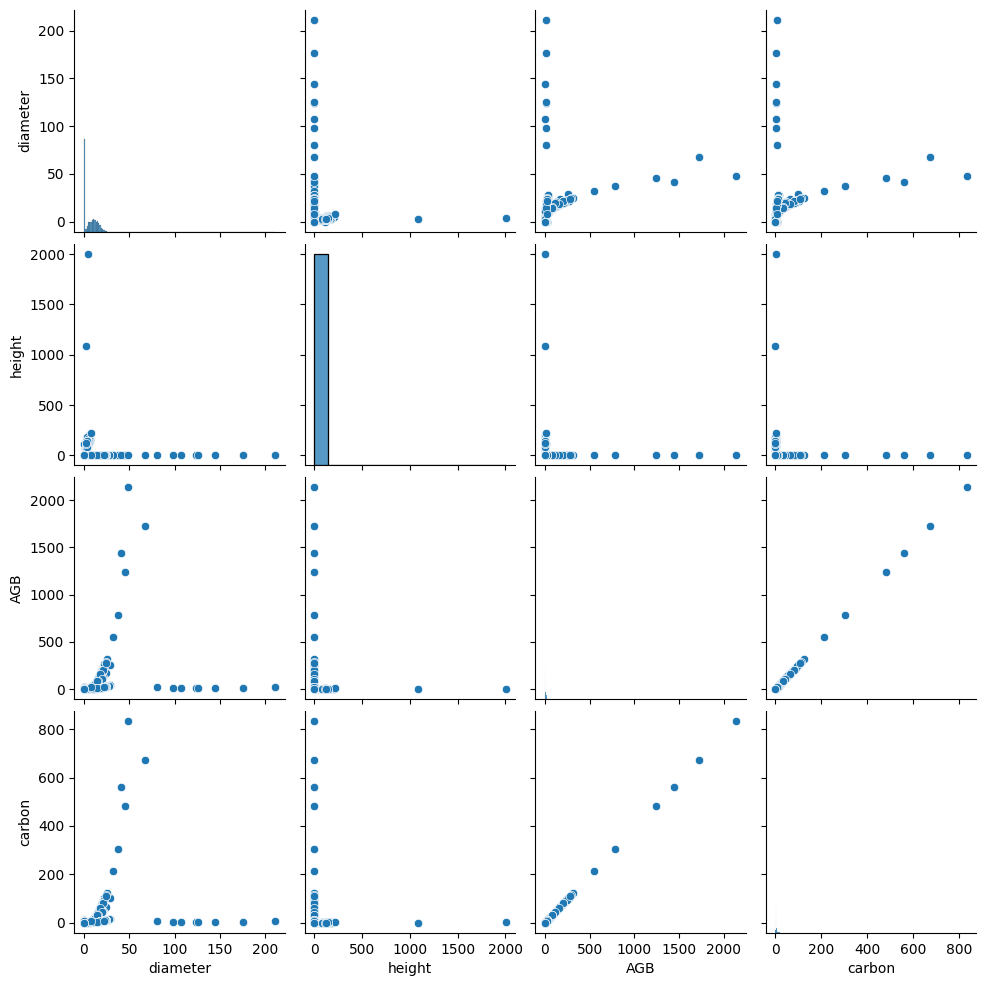

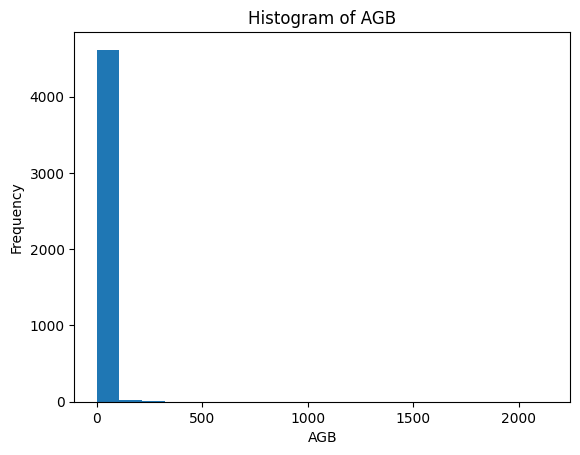

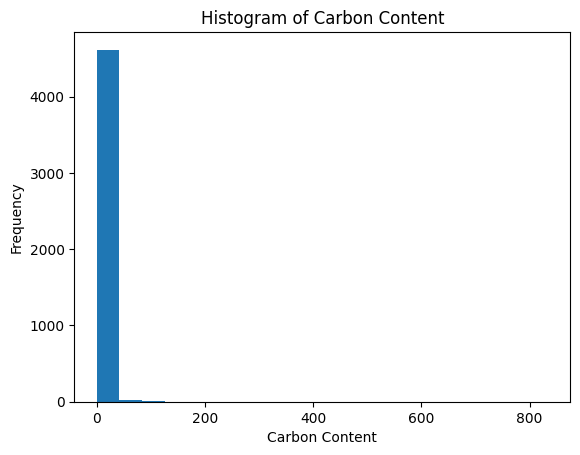

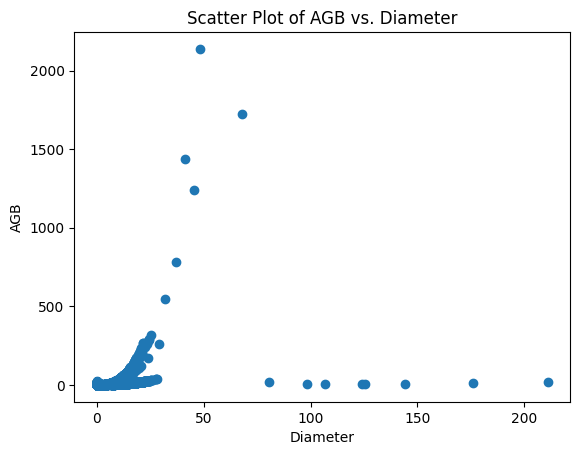

In [17]:
# prompt: visualize data from /content/field_data.csv

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
df = pd.read_csv('/content/field_data.csv')

# Pairplot to visualize relationships between multiple variables
sns.pairplot(df[['diameter', 'height', 'AGB', 'carbon']])
plt.show()

# Histogram of AGB
plt.hist(df['AGB'], bins=20)
plt.xlabel('AGB')
plt.ylabel('Frequency')
plt.title('Histogram of AGB')
plt.show()

# Histogram of Carbon Content
plt.hist(df['carbon'], bins=20)
plt.xlabel('Carbon Content')
plt.ylabel('Frequency')
plt.title('Histogram of Carbon Content')
plt.show()

# Boxplot of AGB by a categorical variable (if available in your dataset)
# For example, if you have a column named 'species'
# sns.boxplot(x='species', y='AGB', data=df)
# plt.show()

# Scatter plot of AGB vs. diameter
plt.scatter(df['diameter'], df['AGB'])
plt.xlabel('Diameter')
plt.ylabel('AGB')
plt.title('Scatter Plot of AGB vs. Diameter')
plt.show()

# Correlation matrix (heatmap)
# correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

# You can add more visualizations based on your specific needs and the data available in your CSV file.
# For example, you might want to visualize the distribution of 'score', 'is_musacea_d', 'is_banana', etc.

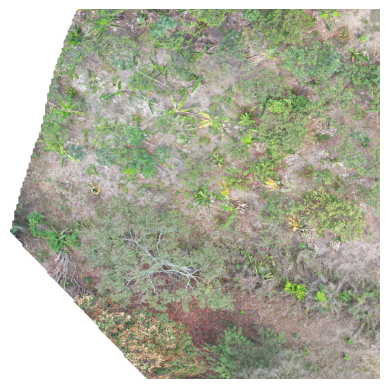

In [18]:
# prompt: show an image from /content/mapping

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Specify the path to the image you want to display
image_path = '/content/tiles/Carlos Vera Arteaga RGB/Carlos Vera Arteaga RGB_2_0_7600_4000_11600.png'  # Replace with the actual path to your image

# Check if the image file exists
if os.path.exists(image_path):
  # Load and display the image
  img = mpimg.imread(image_path)
  plt.imshow(img)
  plt.axis('off')  # Turn off axis labels
  plt.show()
else:
  print(f"Image file not found at: {image_path}")

In [45]:
def run_training():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('device: ', device)
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load dataset
    train_dataset = TreeDataset(csv_file='/content/train_dataset.csv', img_root='/content/tiles', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

    val_dataset = TreeDataset(csv_file='/content/val_dataset.csv', img_root='/content/tiles', transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

    test_dataset = TreeDataset(csv_file='/content/test_dataset.csv', img_root='/content/tiles', transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

    # Load model
    model = load_modified_deepforest_model(freeze_backbone=True)
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Tensorboard writer
    writer = SummaryWriter('runs_grad_bb/deepforest_agb_cc')

    # Training loop
    num_epochs = 20
    best_val_loss = float('inf')    # Initialize best validation loss for model saving

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        train_loss, train_mae_agb, train_mae_cc = train_model(model, train_loader, criterion, optimizer, device, writer, epoch)
        print(f'Training Loss: {train_loss:.4f}, MAE AGB: {train_mae_agb:.4f}, MAE CC: {train_mae_cc:.4f}')

        # Validate the model
        val_loss, val_mae_agb, val_mae_cc = validate_model(model, val_loader, criterion, device, writer, epoch)
        print(f'Validation Loss: {val_loss:.4f}, MAE AGB: {val_mae_agb:.4f}, MAE CC: {val_mae_cc:.4f}')

        # Log epoch losses to TensorBoard
        writer.add_scalar('Epoch/Train_Loss', train_loss, epoch)
        writer.add_scalar('Epoch/Validation_Loss', val_loss, epoch)
        writer.add_scalar('Epoch/Train_MAE_AGB', train_mae_agb, epoch)
        writer.add_scalar('Epoch/Validation_MAE_AGB', val_mae_agb, epoch)
        writer.add_scalar('Epoch/Train_MAE_CC', train_mae_cc, epoch)
        writer.add_scalar('Epoch/Validation_MAE_CC', val_mae_cc, epoch)

        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'deepforest_agb_cc_best_2.pth')
            print('Best model saved!')

    writer.close()



    # run_testing()

In [46]:
run_training()
# model = models.resnet18(pretrained=True)
# remove model.fc
# del model.fc

# print(model)
# /content/tiles/Carlos Vera Arteaga RGB/Carlos Vera Arteaga RGB_0_0_0_4000_4000.png
# /content/train_dataset.csv

device:  cuda
Reading config file: /usr/local/lib/python3.10/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Reading config file: /usr/local/lib/python3.10/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 1/20


  0%|          | 0/204 [00:28<?, ?it/s]


KeyboardInterrupt: 